#### Script to check rf and compute the visuomemory index block 1
- First, check if neuron responding to the task by comparing activity during trial vs baseline
- Second, check whether the rf is in in or out
- Third, compute the visuomemory index

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.analysis import raw_ch,circular_stats
from ephysvibe.task import task_constants,def_task
import os 
from ephysvibe.spike_sorting import config
seed=2023

### Def functions

In [7]:
def get_neurons_info(
    sp_samples: np.ndarray,
    neuron_type: np.ndarray,
    task: pd.DataFrame,
    dur_fix: int,
    st_v: int,
    end_v: int,
    st_d: int,
    end_d: int,
    st_t: int,
    end_t: int,
    clusterdepth: np.ndarray,
    date: str,
    min_trials: int = 3,
    n_spikes: int = 1,
) -> pd.DataFrame:
    # trial_dur = sp_samples.shape[2]
    neurons_info: Dict[str, list] = defaultdict(list)
    i_good, i_mua, n_type = 0, 0, 0
    for i_neuron, type_neuron in enumerate(neuron_type):
        # check and count type of unit
        if type_neuron == "good":
            i_good += 1
            n_type = i_good
        elif type_neuron == "mua":
            i_mua += 1
            n_type = i_mua
        max_in_out = np.array([0, 0])
        larger, v_larger, d_larger, idx_p_min = (
            np.array([False, False]),
            np.array([False, False]),
            np.array([False, False]),
            np.array([0, 0]),
        )
        t_larger = np.nan
        p_in_out, p_v, p_m, vm_index = (
            np.array([None, None]),
            np.array([None, None]),
            np.array([None, None]),
            np.nan,
        )
        tr_min, tr_max, mean_delay_all, mean_visual_all = (
            np.array([np.nan, np.nan]),
            np.array([np.nan, np.nan]),
            np.array([np.nan, np.nan]),
            np.array([np.nan, np.nan]),
        )
        for i, in_out in enumerate(["in", "out"]):  # iterate by code'
            trial_idx = task[
                (task["i_neuron"] == i_neuron)
                & (task["in_out"] == in_out)
                & (task["sample"] != "o0_c0")
            ]["trial_idx"]
            trial_idx = trial_idx[(sp_samples[trial_idx, i_neuron].sum(axis=1) >= n_spikes)]
            n_tr = len(trial_idx)
            true_in_out = "in"
            ## Neurons respnding to the task
            if n_tr > min_trials:
                mean_visual = sp_samples[
                    trial_idx, i_neuron, dur_fix + st_v : dur_fix + end_v
                ].mean(axis=1)
                mean_delay = sp_samples[
                    trial_idx, i_neuron, dur_fix + st_d : dur_fix + end_d
                ].mean(axis=1)
                mean_test = sp_samples[
                    trial_idx, i_neuron, dur_fix + st_t : dur_fix + end_t
                ].mean(axis=1)
                mean_bl = sp_samples[trial_idx, i_neuron, :dur_fix].mean(axis=1)
                v_larger[i] = mean_bl.mean() < mean_visual.mean()
                d_larger[i] = mean_bl.mean() < mean_delay.mean()
                t_larger = mean_bl.mean() < mean_test.mean()
                larger[i] = v_larger[i] or d_larger[i] or t_larger
                # paired sample t-test
                p_v[i] = stats.ttest_rel(mean_bl, mean_visual)[1]
                p_m[i] = stats.ttest_rel(mean_bl, mean_delay)[1]
                p_t = stats.ttest_rel(mean_bl, mean_test)[1]

                p_in_out[i] = np.min([p_v[i], p_m[i], p_t])
                max_in_out[i] = np.max([v_larger[i], d_larger[i], t_larger])
                idx_p_min[i] = np.argmin([p_v[i], p_m[i], p_t])

                all_mean = sp_samples[trial_idx, i_neuron, : dur_fix + end_d].mean(axis=0)
                tr_min[i], tr_max[i] = np.min(all_mean), np.max(all_mean)
                mean_delay_all[i], mean_visual_all[i] = (
                    mean_delay.mean(),
                    mean_visual.mean(),
                )
        # Get receptive field
        if not np.all(np.isnan(tr_min)):
            tr_max_all = np.nanmax(tr_max)  # - tr_min_all
            if not(p_v[0] is None):
                p_and_large_in = np.any(
                    np.logical_and(
                        np.array([p_v[0], p_m[0]]) < 0.05,
                        np.array([v_larger[0], d_larger[0]]),
                    )
                )
            if not(p_v[0] is None) and p_and_large_in:
                mean_delay = (mean_delay_all[0]) / tr_max_all  # - tr_min_all
                mean_visual = (mean_visual_all[0]) / tr_max_all  # - tr_min_all
                vm_index = (mean_delay - mean_visual) / (mean_delay + mean_visual)
            else:
                if not(p_v[1] is None):
                    p_and_large_out = np.any(
                        np.logical_and(
                            np.array([p_v[1], p_m[1]]) < 0.05,
                            np.array([v_larger[1], d_larger[1]]),
                        )
                    )
                if not(p_v[1] is None) and p_and_large_out:
                    true_in_out = "out"
                    mean_delay = (mean_delay_all[1]) / tr_max_all  # - tr_min_all
                    mean_visual = (mean_visual_all[1]) / tr_max_all  # - tr_min_all
                    vm_index = (mean_delay - mean_visual) / (mean_delay + mean_visual)

        for i, in_out in enumerate(["in", "out"]):  # iterate by code'
            neurons_info["array_position"] += [i_neuron]
            neurons_info["cluster"] += [n_type]
            neurons_info["group"] += [type_neuron]
            neurons_info["in_out"] += [in_out]
            neurons_info["true_in_out"] += [true_in_out]
            neurons_info["vm_index"] += [vm_index]
            neurons_info["p"] += [p_in_out[1]]
            neurons_info["larger"] += [larger[i]]
            neurons_info["v_larger"] += [v_larger[i]]
            neurons_info["p_v"] += [p_v[i]]
            neurons_info["d_larger"] += [d_larger[i]]
            neurons_info["p_m"] += [p_m[i]]
            neurons_info["depth"] += [clusterdepth[i_neuron]]
            neurons_info["date"] += [date]
    neurons_info = pd.DataFrame(neurons_info)
    return neurons_info

### Start analysis

In [8]:
# load data
filepath = "/home/INT/losada.c/Documents/data/Riesling/session_struct/lip/spikes/2023-01-18_10-22-38_Riesling_lip_e1_r1_sp.h5"  #2023-02-27_10-50-03 2023-01-18_10-22-38 2023-03-21_10-40-02
bhv_path = '/home/INT/losada.c/Documents/data/Riesling/session_struct/bhv/2023-01-18_10-22-38_Riesling_e1_r1_bhv.h5'
s_path = os.path.normpath(filepath).split(os.sep)
data = SpikeData.from_python_hdf5(filepath)
bhv = BhvData.from_python_hdf5(bhv_path)

In [9]:
# Select trials and create task frame
block = 1
trials_block = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 7


In [10]:
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond = data.neuron_cond
task = def_task.create_task_frame(
    condition=bhv.condition[trials_block],
    test_stimuli=bhv.test_stimuli[trials_block],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond=neuron_cond,
)

In [11]:
neuron_type = data.clustersgroup
code_samples = data.code_samples[trials_block]
code_numbers = data.code_numbers[trials_block]
sp_samples = data.sp_samples[trials_block]

#### Select parameters

In [12]:
# Timings 
## fixation
dur_fix = 200
## visual stim
st_v =   50
end_v = 250
## delay
st_d = 500 
end_d = 500 +400
## test
st_t = 950
end_t = 950 + 400
# trials and threshold
min_trials = 3
n_spikes = 1
p_threshold = 0.05
vm_threshold = 0.4

In [13]:
shifts_on = code_samples[:,4]  
shifts_on = shifts_on[:,np.newaxis]
shifts_on = np.where(np.isnan(shifts_on),0,shifts_on)
shifts_test = code_samples[:,6]
shifts_test = shifts_test[:,np.newaxis]
shifts_test = np.where(np.isnan(shifts_test),0,shifts_test)
sp_shift_on = SpikeData.indep_roll(sp_samples, -(shifts_on-dur_fix).astype(int), axis=2)[:,:,:end_d+dur_fix]
sp_shift_test = SpikeData.indep_roll(sp_samples, -(shifts_test).astype(int), axis=2)[:,:,:end_t-st_t]
sp_shift = np.concatenate([sp_shift_on,sp_shift_test],axis=2)

#### Select responding neurons and check rf

In [14]:
task

,i_neuron,trial_idx,sample,in_out,n_test_stimuli,code
0,0,2,o1_c1,in,4,4
1,0,4,o1_c1,in,4,4
2,0,7,o1_c1,in,5,5
3,0,13,o1_c1,in,5,6
4,0,19,o1_c1,in,2,2
...,...,...,...,...,...,...
2333,6,306,o5_c5,out,3,3
2334,6,310,o5_c5,out,5,6
2335,6,312,o5_c5,out,1,1
2336,6,321,o5_c5,out,3,3


In [15]:
neurons_info = get_neurons_info(
    sp_shift,
    neuron_type,
    task,
    dur_fix=dur_fix,
    st_v = st_v,
    end_v=end_v,
    st_d=st_d,
    end_d=end_d,
    st_t=st_t,
    end_t=end_t,
    min_trials=min_trials,
    n_spikes = n_spikes,
    clusterdepth=data.clusterdepth,
    date=s_path[-1][:19],
)
neurons_info = neurons_info[(neurons_info['p']<p_threshold) & (neurons_info['larger']==True)] # responding neurons


#### Compute vm index

In [16]:
neurons_info = neurons_info[neurons_info["in_out"]==neurons_info["true_in_out"]]
neurons_info = neurons_info[(np.logical_and(neurons_info["p_v"]<p_threshold,neurons_info["v_larger"]==True)) | (np.logical_and(neurons_info["p_m"]<p_threshold,neurons_info["d_larger"]==True))]

In [17]:
neurons_info

,array_position,cluster,group,in_out,true_in_out,vm_index,p,larger,v_larger,p_v,d_larger,p_m,depth,date
4,2,2,mua,in,in,-0.550388,3.050391e-13,True,True,2.162838e-18,True,4.594604e-01,1150.0,2023-01-18_10-22-38
8,4,3,good,in,in,0.364303,1.143788e-04,True,True,2.834731e-04,True,5.733431e-18,1250.0,2023-01-18_10-22-38
10,5,3,mua,in,in,-0.019711,4.500407e-10,True,True,2.069035e-12,True,1.340159e-14,1300.0,2023-01-18_10-22-38
12,6,4,mua,in,in,-0.584906,1.418627e-03,True,True,9.878983e-15,True,9.212075e-03,1400.0,2023-01-18_10-22-38


In [18]:
# define kernel for convolution
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)

/tmp/ipykernel_9399/1153093432.py:42: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2[i_ax].scatter(cols-t_before,rows+count_trials, marker='|', alpha=1,edgecolors='none',color=task_constants.PALETTE_B1[i_sample],label="Sample %s" % i_sample)


Text(0.05, 0.99, 'lip: good 3 ')

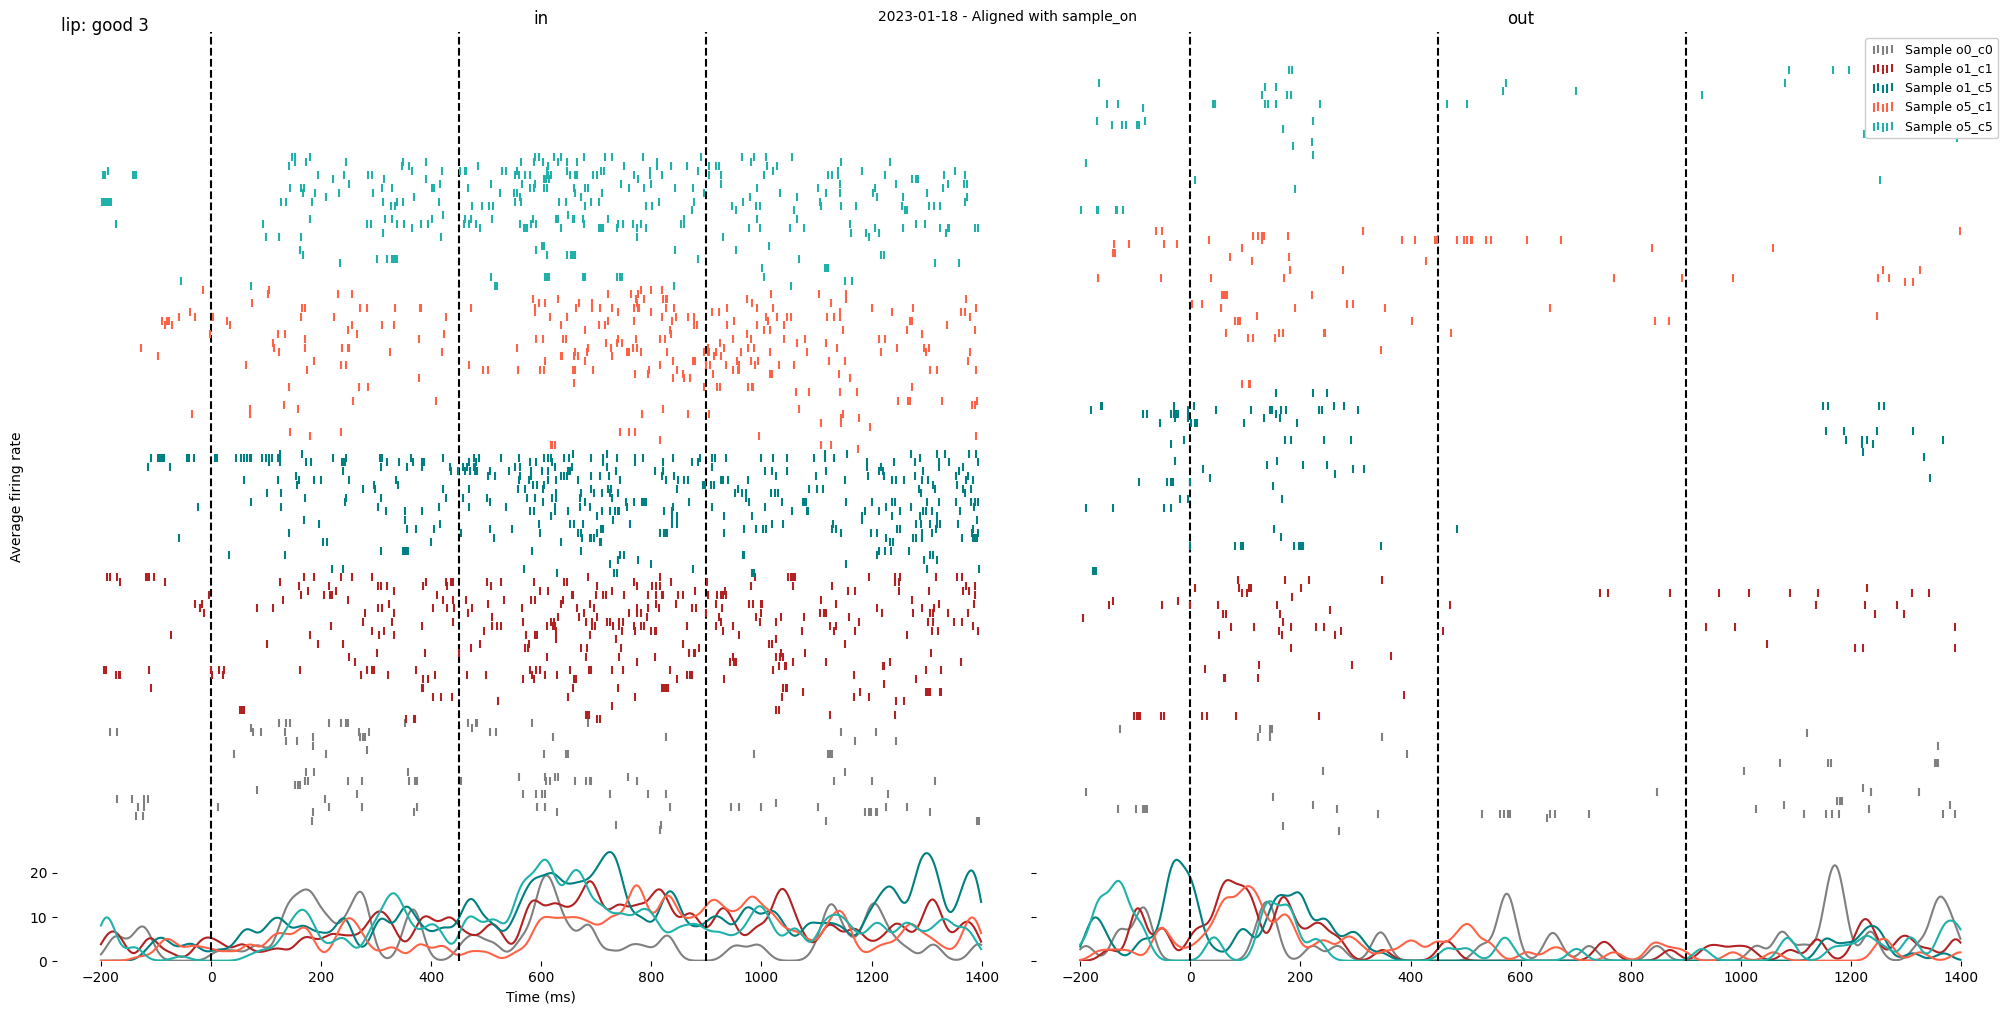

In [25]:
i_neuron = 4
neuron_type = data.clustersgroup[i_neuron]
i_neu = np.sum(data.clustersgroup[:i_neuron+1]==neuron_type)

t_before = 200
trials_s_on = data.code_samples[
    trials_block,
    np.where(data.code_numbers[trials_block] == task_constants.EVENTS_B1["sample_on"])[
        1
    ],
]
samples = np.sort(np.unique(task["sample"].values))
neuron_sp = sp_samples[:, i_neuron, :]
shift_sp = SpikeData.indep_roll(neuron_sp, -(trials_s_on - t_before).astype(int), axis=1)[:, :1600]
# Iterate by sample and condition
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
ax2 = [ax[0].twinx(), ax[1].twinx()]
all_max_conv = 0
all_max_trial = 0
for i_ax, cond in enumerate(["in", "out"]):
    count_trials =  0
    max_conv = 0
    for i_s, i_sample in enumerate(samples):
        sample_idx = task[
            np.logical_and(task["i_neuron"] == i_neuron,np.logical_and(task["in_out"] == cond, task["sample"] == i_sample))
        ]["trial_idx"].values
        # Select trials with at least 2 spikes/sec 
        bool_shift_sp = np.sum(shift_sp[sample_idx],axis=1)>=np.floor(2 * (shift_sp[sample_idx].shape[1]/1000))
        mean_sp = np.zeros(shift_sp.shape[1])
        if np.sum(bool_shift_sp)>3:
            mean_sp = shift_sp[sample_idx][bool_shift_sp].mean(axis=0)
        conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        max_conv = np.max(conv) if np.max(conv) > max_conv else max_conv
        time = np.arange(0,len(conv))-t_before
        ax[i_ax].plot( time,
            conv,
            color=task_constants.PALETTE_B1[i_sample],
        )
        # Plot spikes
        count_t = len(sample_idx)
        rows,cols = np.where(shift_sp[sample_idx]>=1)
        ax2[i_ax].scatter(cols-t_before,rows+count_trials, marker='|', alpha=1,edgecolors='none',color=task_constants.PALETTE_B1[i_sample],label="Sample %s" % i_sample)
        count_trials +=count_t
    all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
    all_max_trial = count_trials if count_trials > all_max_trial else all_max_trial
    ax[i_ax].set_title(cond)
for i_ax in range(2):
    ax[i_ax].set_ylim(0,all_max_conv+all_max_trial+5)
    ax[i_ax].set_yticks(np.arange(0, all_max_conv+5,10))
    ax2[i_ax].set_yticks(np.arange(-all_max_conv-5, all_max_trial))
    plt.setp(ax2[i_ax].get_yticklabels(), visible=False)
    plt.setp(ax2[i_ax].get_yaxis(), visible=False)
    ax[i_ax].vlines(
            [0,450,900],
            0,
            all_max_conv+all_max_trial+5,
            color='k',
            linestyles="dashed",
        )
    ax2[i_ax].spines["right"].set_visible(False)
    ax2[i_ax].spines["left"].set_visible(False)
    ax2[i_ax].spines["top"].set_visible(False)
    ax2[i_ax].spines["bottom"].set_visible(False)
    ax[i_ax].spines["right"].set_visible(False)
    ax[i_ax].spines["left"].set_visible(False)
    ax[i_ax].spines["top"].set_visible(False)
    ax[i_ax].spines["bottom"].set_visible(False)
ax[0].set(xlabel="Time (ms)", ylabel="Average firing rate")
ax2[1].set(xlabel="Time (ms)", ylabel="trials")
ax2[1].legend(fontsize=9,scatterpoints=5,columnspacing=0.5,facecolor='white', framealpha=1,loc='upper right')

# fig.legend()
fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
fig.text(
    0.5,
    0.99,
    s="%s - Aligned with %s"
    % (s_path[-1][:-4][:10], list(task_constants.EVENTS_B1.keys())[2]),
    horizontalalignment="center",
    verticalalignment="center",
)
ss_path = s_path[-1][:-3]
fig.suptitle("%s: %s %d " % (s_path[-3], neuron_type, i_neu ), x=0.05, y=0.99)
#fig.savefig(ss_path + "_" + cgroup + "_" + str(i_neuron + 1) +'.svg', bbox_inches="tight",transparent=True)
#fig.savefig(ss_path + "_" + cgroup + "_" + str(i_neuron + 1) +'.pdf', bbox_inches="tight",transparent=True)